# Прогнозирование коэффициента восстановления золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий. Нужно разработать модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Содержание**

1. [Подготовка данных](#preprocessing)
    * [Обзор данных](#overview)
    * [Проверка правильности расчета эффективности обогащения](#recoverycheck)
    * [Предобработка данных](#preproc)
    
    
2. [Исследовательский анализ данных](#dataanalysis)
    * [Концентрация металлов на разных этапах очистки](#process)
    * [Сравнение распределений размеров гранул в обучающей и тестовой выборках](#sizes)
    * [Суммарная концентрация веществ на разных этапах очистки](#sumprocess)
    
    
3. [Обучение и проверка модели](#models)
    * [Функции для расчета метрик качества](#metrics)
    * [Подготовка к обучению моделей](#inputmodels)
    * [Модель случайного леса](#randomforest)
    * [Модель линейной регрессии](#linearregression)
    * [Модель линейной регрессии (Lasso)](#lasso)
    * [Проверка модели на адекватность](#modelcheck)
    

[Выводы](#summary)

# 1. Подготовка данных <a id = 'preprocessing'></a>

## Обзор данных <a id = 'overview'></a>

Импортируем библиотеки, сохраним файлы в переменные `data`, `data_train` и `data_test` и посмотрим на первые строки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [2]:
data = pd.read_csv('gold_recovery_full.csv')
data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
data_train = pd.read_csv('gold_recovery_train.csv')
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_test = pd.read_csv('gold_recovery_test.csv')
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


В датасетах много признаков. Они относятся к разным этапам процесса обогащения:
    
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики.

Представлены разные типы параметров:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики.

Посмотрим, что означают признаки, характеризующие технологический процесс:

- rougher additions — флотационные реагенты: Xanthate, Sulphate, Depressant
- float banks — флотационная установка
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

И наиболее важные параметры эффективности процесса очистки:

(наши целевые признаки)
- эффективность обогащения чернового концентрата: rougher.output.recovery
- эффективность обогащения финального концентрата: final.output.recovery

(признаки, которые используются для расчета эффективности)
- Rougher feed — исходное сырье
- Rougher tails — отвальные хвосты
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота.

Узнаем количество данных в каждом датасете и выясним, к какому типу относятся данные.

### Полный датасет

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Обучающая выборка

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


### Тестовая выборка

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Все данные числовые, кроме первого столбца: в нем содержатся даты в формате *object*. Приведем даты к формату *datetime*:

In [8]:
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format = '%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format = '%Y-%m-%d %H:%M:%S')

### Обучающая и тестовая выборка

В полном и обучающем датасетах - 87 столбцов, а в тестовом - только 53. Какие признаки отсутствуют в тестовом датасете?

In [9]:
list(np.setdiff1d(data_train.columns.to_list(), data_test.columns.to_list()))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовом наборе отсутствуют целевые признаки (`rougher.output.recovery` и `final.output.recovery`), а также расчётные характеристики (`....calculation....`). 

Также отсутствуют параметры продукта на каждом этапе очистки (`....output....`) - показатели и по концентратам, и по отвальным хвостам. Эти параметры замеряются или рассчитываются уже по завершении процесса очистки.

Наша задача - обучить модель, которая сможет предсказывать эффективность обогащения, основываясь лишь на данных об исходном сырье и характеристиках технологического процесса (тип флотационного реагента, объем воздуха, уровень жидкости, скорость подачи и т.д.).

То есть, те столбцы, которые отсутствуют в тестовой выборке, при обучении модели также не будут использоваться.

А вот целевые признаки, отсутствующие в тестовой выборке, понадобятся нам, чтобы сравнить предсказания модели с правильными ответами. Сохраним значения целевых признаков, соответствующие наблюдениям в тестовой выборке, для дальнейшей работы.

In [10]:
data['date'].nunique()

22716

In [11]:
data_test['date'].nunique()

5856

Как видим, значения в столбце `date` уникальны: значит, можно соотнести наблюдения из тестовой выборки и из полного датасета по этому столбцу:

In [12]:
# создадим копию полного датасета, сделаем его индексом столбец с датой
df_full = data.set_index('date')

In [13]:
# создадим копию тестового датасета, сделаем его индексом столбец с датой
df_test = data_test.set_index('date')

In [14]:
# сохраним в переменную target значения целевых признаков, соответствующие индексам тестовой выборки
target = df_full.loc[df_test.index, ['rougher.output.recovery', 'final.output.recovery']]
# удалим из target индексы, для которых целевые признаки неизвестны
target.dropna(inplace = True)
# по оставшимся индексам, для которых целевые признаки заполнены, отфильтруем тестовую выборку
data_test = df_test.loc[target.index, :].reset_index(drop = True)
# в тестовой выборке data_test остались только нужные строки, столбец с датой мы удалили
# в target сохранены целевые признаки, соответствующие наблюдениям из data_test

In [15]:
data_test.shape

(5290, 52)

In [16]:
target.shape

(5290, 2)

В тестовой выборке `data_test` остались только те наблюдения, для которых известны целевые признаки.

Целевые признаки сохранены в `target`.

## Проверка правильности расчета эффективности обогащения <a id = 'recoverycheck'></a>

Проверим, правильно ли вычислена эффективность обогащения. Вычислим её на обучающей выборке для признака `rougher.output.recovery`, а затем найдем MAE между расчетными значениями и значениями признака в датасете.

Сохраним в новый датасет `data1` только столбцы, необходимые для расчета, и признак `rougher.output.recovery`, за исключением пропусков:

In [17]:
data1 = data_train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'rougher.output.recovery']].dropna()
data1.shape

(14287, 4)

In [18]:
data1.head()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery
0,6.486150,19.793808,1.170244,87.107763
1,6.478583,20.050975,1.184827,86.843261
2,6.362222,19.737170,1.162562,86.842308
3,6.118189,19.320810,1.079755,87.226430
4,5.663707,19.216101,1.012642,86.688794


Напишем функцию для расчета эффективности очистки:

In [19]:
def recovery(data, F, C, T):
    recovery = (data[C] * (data[F] - data[T])) / (data[F] * (data[C] - data[T])) * 100
    return recovery

Высчитаем эффективность очистки по формуле с помощью функции и сохраним как новый столбец в `data1`:

In [20]:
rougher_recovery_true = recovery(data1, 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au')

In [21]:
data1['rougher.output.recovery.true'] = rougher_recovery_true
data1.head()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery,rougher.output.recovery.true
0,6.486150,19.793808,1.170244,87.107763,87.107763
1,6.478583,20.050975,1.184827,86.843261,86.843261
2,6.362222,19.737170,1.162562,86.842308,86.842308
3,6.118189,19.320810,1.079755,87.226430,87.226430
4,5.663707,19.216101,1.012642,86.688794,86.688794


Высчитаем MAE:

In [22]:
print(mean_absolute_error(data1['rougher.output.recovery.true'], data1['rougher.output.recovery']))

9.444891926100695e-15


Есть погрешность, но она настолько маленькая, что ею можно пренебречь. Наши расчеты совпадают с показателями в датасете. Эффективность обогащения рассчитана верно.

На всякий случай проверим правильность расчета в полном датасете и по обоим целевым показателям:

In [23]:
data2 = data[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'rougher.output.recovery']].dropna()
all_rougher_recovery_true = recovery(data2, 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au')
data2['rougher.output.recovery.true'] = all_rougher_recovery_true

In [24]:
print(mean_absolute_error(data2['rougher.output.recovery.true'], data2['rougher.output.recovery']))

9.816196887783512e-15


In [25]:
data2.head()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery,rougher.output.recovery.true
0,6.486150,19.793808,1.170244,87.107763,87.107763
1,6.478583,20.050975,1.184827,86.843261,86.843261
2,6.362222,19.737170,1.162562,86.842308,86.842308
3,6.118189,19.320810,1.079755,87.226430,87.226430
4,5.663707,19.216101,1.012642,86.688794,86.688794


In [26]:
data3 = data[['rougher.input.feed_au', 'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']].dropna()
all_final_recovery_true = recovery(data3, 'rougher.input.feed_au', 'final.output.concentrate_au', 'final.output.tail_au')
data3['final.output.recovery.true'] = all_final_recovery_true

In [27]:
print(mean_absolute_error(data3['final.output.recovery.true'], data3['final.output.recovery']))

8.514919897738086e-15


In [28]:
data3.head()

,rougher.input.feed_au,final.output.concentrate_au,final.output.tail_au,final.output.recovery,final.output.recovery.true
0,6.486150,42.192020,2.143149,70.541216,70.541216
1,6.478583,42.701629,2.224930,69.266198,69.266198
2,6.362222,42.657501,2.257889,68.116445,68.116445
3,6.118189,42.689819,2.146849,68.347543,68.347543
4,5.663707,42.774141,2.055292,66.927016,66.927016


Как видим, целевые признаки заполнены верно: наши расчеты подтверждают данные в столбцах `rougher.output.recovery` и `final.output.recovery`.

## Предобработка данных <a id = 'preproc'></a>

Избавимся от пропусков. 

Сначала изучим пропуски в целевых признаках. Поскольку мы знаем, как они высчитываются, мы можем заполнить пропуски, если известны показатели, на основе которых можно вычислить целевые признаки.

In [29]:
data_train[data_train['rougher.output.recovery'].isna()][['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'rougher.output.recovery']].isna().sum()

rougher.input.feed_au              83
rougher.output.concentrate_au      82
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64

Не получится: подавляющее большинство пропусков в целевом признаке `rougher.output.recovery` невозможно восстановить, т.к. отсутствуют исходные данные, на основе которых можно было бы вычислить эффективность процесса флотации.

In [30]:
data_train[data_train['final.output.recovery'].isna()][['rougher.input.feed_au', 'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']].isna().sum()

rougher.input.feed_au            83
final.output.concentrate_au      71
final.output.tail_au             66
final.output.recovery          1521
dtype: int64

Здесь, казалось бы, можно вычислить `final.output.recovery` по имеющимся данным. 

Но довольно странно, что при отсутствующих данных о концентрации золота на предыдущих этапах (`rougher.output.tail_au`) финальные показатели (`final.output.concentrate_au`, `final.output.tail_au`) есть в датасете. 

Возможно, они неверные, в этом случае и целевой признак будет посчитан неправильно. Лучше удалим эти пропуски, чтобы избежать ошибок.

In [31]:
# количество строк в обучающей выборке до удаления пропусков в целевых признаках
len(data_train)

16860

In [32]:
data_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)

In [33]:
# количество строк в обучающей выборке после удаления пропусков в целевых признаках
len(data_train)

14149

Посмотрм, в каких столбцах остались пропуски и сколько их:

In [34]:
data_train.isna().sum().sort_values(ascending = False).head(20)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
final.output.tail_pb                         100
rougher.input.feed_pb                        100
primary_cleaner.input.xanthate               100
primary_cleaner.output.concentrate_pb         86
rougher.input.feed_sol                        78
primary_cleaner.output.tail_sol               46
rougher.input.floatbank11_sulfate             36
primary_cleaner.input.depressant              32
rougher.input.floatbank10_sulfate             29
rougher.output.concentrate_sol                22
secondary_cleaner.state.floatbank2_b_air      21
primary_cleaner.input.sulfate                 20
primary_cleaner.output.tail_pb                15
dtype: int64

Пропусков все еще очень много. 

Избавимся от пропусков в тех признаках, которые понадобятся нам для обучения модели. Это те столбцы, которые есть в датасете `data_test`.

In [35]:
# сохраним названия столбцов тестовой выборки в отдельный список
cols = data_test.columns.to_list()
cols

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

In [36]:
# удалим пропуски в обучающей выборке в тех столбцах, которые понадобятся для обучения модели
data_train.dropna(subset = cols, inplace = True)

In [37]:
# количество наблюдений в обучающей выборке после удаления пропусков
len(data_train)

12679

Теперь подготовим тестовую выборку. В ней также нужно избавиться от пропусков.

In [38]:
# количество наблюдений в тестовой выборке
len(data_test)

5290

In [39]:
# количество пропусков в тествовой выборке
data_test.isna().sum().sum()

90

Используем инструмент IterativeImputer, который заполняет пропуски в каждом столбце, используя значения других столбцов.

In [40]:
imp = IterativeImputer(random_state=0, sample_posterior = True)
data_test = pd.DataFrame(imp.fit_transform(data_test), columns = cols)

In [41]:
# проверим, что в тестовой выборке не осталось пропусков
data_test.isna().sum().sum()

0

# 2. Анализ данных <a id = 'dataanalysis'></a>

## Концентрация металлов на разных этапах очистки <a id = 'process'></a>

Посмотрим, как меняется концентрация металлов на каждом этапе очистки:

### Золото

In [42]:
data_train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'final.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'final.output.tail_au']].median()

rougher.input.feed_au                     7.636738
rougher.output.concentrate_au            20.021534
rougher.output.tail_au                    1.761817
primary_cleaner.output.concentrate_au    33.150646
primary_cleaner.output.tail_au            3.513575
final.output.concentrate_au              44.862487
secondary_cleaner.output.tail_au          4.005352
final.output.tail_au                      2.854488
dtype: float64

Медианное значение доли золота в исходном сырье - около 7.63%. 

После флотации содержание золота повышается до 20%, после первого этапа очистки - до 33.15%, а после второго - до 44.86%. 

В то же время, содержание золота в отвальных хвостах тоже увеличивается после каждого этапа очистки, хотя и не так радикально: 1.76% после флотации, 3.5% после первого этапа очистки, 4% после второго этапа. Всего в отвальных хвостах содержится 2.85% золота.

### Серебро

In [43]:
data_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'rougher.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'final.output.tail_ag']].median()

rougher.input.feed_ag                     8.127036
rougher.output.concentrate_ag            11.711215
rougher.output.tail_ag                    5.747940
primary_cleaner.output.concentrate_ag     8.228233
primary_cleaner.output.tail_ag           15.650973
final.output.concentrate_ag               4.942581
secondary_cleaner.output.tail_ag         15.225281
final.output.tail_ag                      9.520423
dtype: float64

В случае с серебром очистка выглядит не слишком эффективной: в отвальных хвостах остается очень много ценного металла (9.52%).

### Свинец

In [44]:
data_train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'final.output.tail_pb']].median()

rougher.input.feed_pb                     3.435598
rougher.output.concentrate_pb             7.766446
rougher.output.tail_pb                    0.629310
primary_cleaner.output.concentrate_pb     9.933393
primary_cleaner.output.tail_pb            3.185504
final.output.concentrate_pb              10.372350
secondary_cleaner.output.tail_pb          5.397785
final.output.tail_pb                      2.592227
dtype: float64

В случае со свинцом доля металла в исходном сырье - около 3.43%. После процесса обогащения ее удается увеличить до 10.37%.

## Сравнение распределений размеров гранул <a id = 'sizes'></a>

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [45]:
# параметры распределения в обучающей выборке
data_train['rougher.input.feed_size'].describe()

count    12679.000000
mean        58.414412
std         20.441275
min          9.659576
25%         48.721041
50%         54.651129
75%         63.719220
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [46]:
# параметры распределения в тестовой выборке
data_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.942999
std        19.089043
min         0.046369
25%        43.905687
50%        50.834264
75%        62.425276
max       392.494040
Name: rougher.input.feed_size, dtype: float64

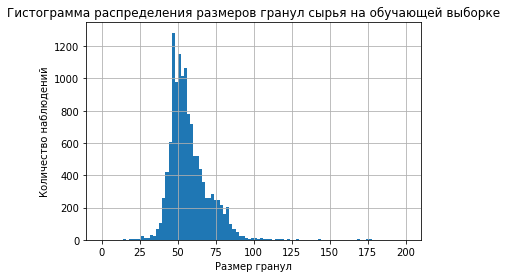

In [47]:
data_train['rougher.input.feed_size'].hist(bins = 100, range = (0, 200))
plt.title('Гистограмма распределения размеров гранул сырья на обучающей выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений');

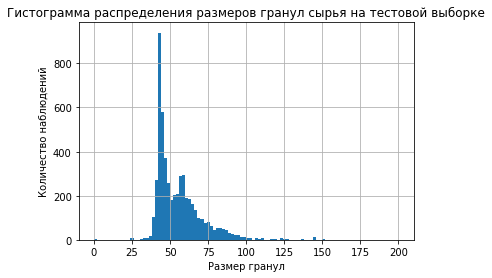

In [48]:
data_test['rougher.input.feed_size'].hist(bins = 100, range = (0, 200))
plt.title('Гистограмма распределения размеров гранул сырья на тестовой выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений');

Распределения в целом похожи. Стандартное отклонение, средние и медианные значения близки в обеих выборках. Оба графика сильно скошены вправо. На тестовой выборке это более заметно, т.к. в ней сильно меньше наблюдений.

## Суммарная концентрация веществ на разных этапах очистки <a id = 'sumprocess'></a>

 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

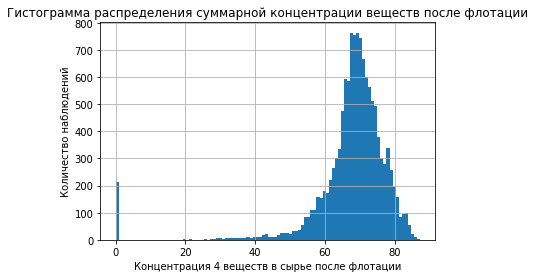

In [49]:
rougher_concentrate = data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol']
rougher_concentrate.hist(bins = 100)
plt.title('Гистограмма распределения суммарной концентрации веществ после флотации')
plt.xlabel('Концентрация 4 веществ в сырье после флотации')
plt.ylabel('Количество наблюдений');

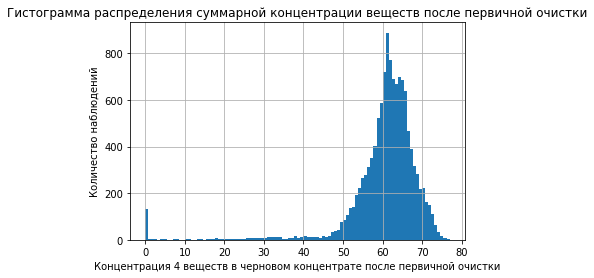

In [50]:
primary_concentrate = data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] + data_train['primary_cleaner.output.concentrate_pb'] + data_train['primary_cleaner.output.concentrate_sol']
primary_concentrate.hist(bins = 100)
plt.title('Гистограмма распределения суммарной концентрации веществ после первичной очистки')
plt.xlabel('Концентрация 4 веществ в черновом концентрате после первичной очистки')
plt.ylabel('Количество наблюдений');

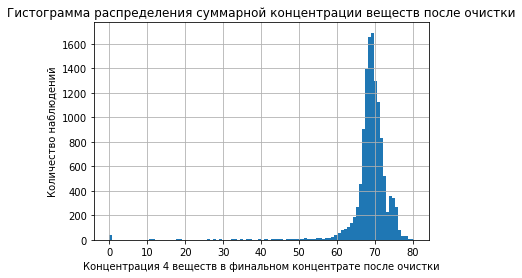

In [51]:
final_concentrate = data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_sol']
final_concentrate.hist(bins = 100)
plt.title('Гистограмма распределения суммарной концентрации веществ после очистки')
plt.xlabel('Концентрация 4 веществ в финальном концентрате после очистки')
plt.ylabel('Количество наблюдений');

Мы уже сталкивались с похожей ситуацией, когда были пропущены данные о содержании золота на ранних этапах очистки, а финальные показатели присутствовали. Здесь то же самое, только имеем дело не с пропусками, а с нулевыми значениями. На первом этапе очистки более 200 наблюдений с нулевыми значениями, на финальном этапе их почти нет.

Очевидно, если содержание золота в сырье 0, то и в финальном концентрате золота не будет. Скорее всего, из-за какого-то сбоя при сборе данных часть значений пропущена или заменена нулями, но данные о концентрации на следующих этапах очистки есть.

Нужно ли удалять эти аномальные значения? При обучении модели мы не будем использовать данные о концентрации веществ на разных этапах, а только параметры исходного сырья и характеристики технологического процесса. Нам важно, чтобы присутствовали и были корректно рассчитаны целевые признаки, которые будет предсказывать модель.

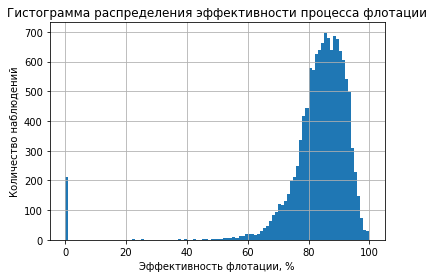

In [52]:
data_train['rougher.output.recovery'].hist(bins = 100)
plt.title('Гистограмма распределения эффективности процесса флотации')
plt.xlabel('Эффективность флотации, %')
plt.ylabel('Количество наблюдений');

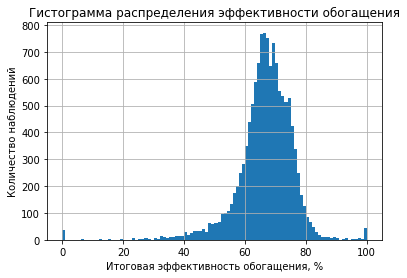

In [53]:
data_train['final.output.recovery'].hist(bins = 100)
plt.title('Гистограмма распределения эффективности обогащения')
plt.xlabel('Итоговая эффективность обогащения, %')
plt.ylabel('Количество наблюдений');

С целевыми признаками такая же ситуация. Эти 200 с лишним наблюдений можно было бы использовать для предсказания `final.output.recovery`, но не `rougher.output.recovery`. Они составляют менее 1,5% тренировочного датасета. Лучше удалим их, чтобы ошибки не повлияли на качество модели. 

На графике заметны и другие аномальные значения, где итоговая эффективность близка к 100%. Таких выбросов немного, и скорее всего эти наблюдения содержат ошибки, поэтому их лучше тоже удалить.

In [54]:
len(data_train[data_train['final.output.recovery'] >= 98][['rougher.output.recovery', 'final.output.recovery']])

47

In [55]:
# количество наблюдений до удаления аномальных значений
len(data_train)

12679

In [56]:
# удаляем аномальные значения
data_train.drop(data_train[(data_train['rougher.output.recovery'] == 0) | (data_train['final.output.recovery'] == 0) | (data_train['final.output.recovery'] >= 98)].index, inplace = True)

In [57]:
# количество наблюдений после удаления нулей
len(data_train)

12387

# 3. Обучение и проверка модели <a id = 'models'></a>

## Функции для расчета метрик качества <a id = 'metrics'></a>

Напишем функции для вычисления sMAPE и итоговой метрики:

In [58]:
# функция для расчета sMAPE
def smape(targ, pred):
    smape = 1/len(targ) * sum(2 * abs(targ - pred) / (abs(targ) + abs(pred))) * 100
    return smape

In [59]:
# функция для расчета итоговой метрики качества
def finsmape(smape1, smape2):
    return (0.25 * smape1 + 0.75 * smape2)

## Подготовка к обучению моделей <a id = 'inputmodels'></a>

Подготовим данные для обучения модели.

Мы уже удалили ненужные признаки, но в обучающей выборке все еще слишком много столбцов с неочевидным содержанием. Посмотрим, как взаимосвязаны между собой эти признаки:

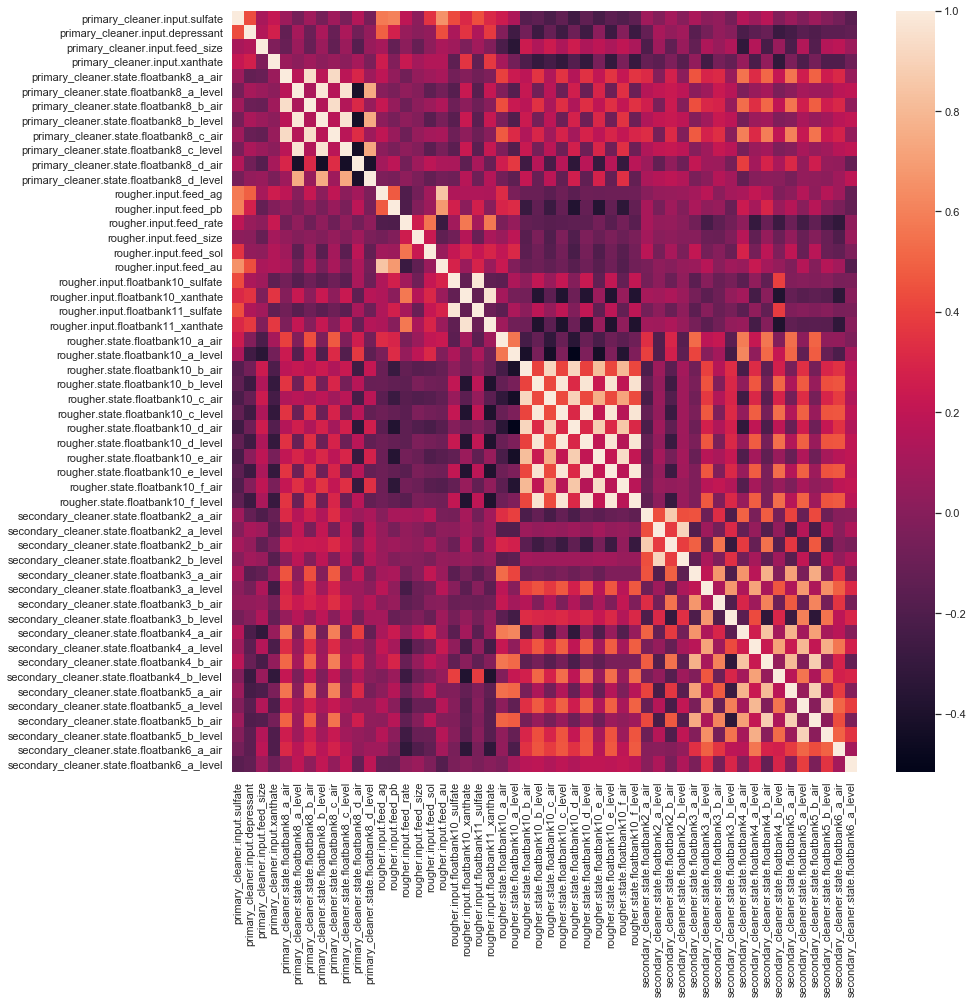

In [60]:
# построим матрицу корреляции и визуализируем ее
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(data_train[cols].corr())

Заметно, что признаки, помеченные буквами 'a_' и 'b_', сильно коррелируют между собой. То же самое можно сказать о признаках, помеченных 'c_' и 'd_', 'e_' и 'f_'. 

Создадим новый список с названиями столбцов, удалив столбцы с названиями, содержащими 'b_', 'd_', 'f_'.

Отфильтруем обучающий и тестовый датасеты по этому новому сокращенному списку столбцов, чтобы избавиться от мультиколлинеарности в признаках.

In [61]:
cols2 = [c for c in cols if not ('b_' in c) | ('d_' in c) | ('f_' in c)]
cols2

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.s

In [62]:
# X - признаки для обучения модели, y1 и y2 - целевые признаки
y1 = data_train['rougher.output.recovery'].to_numpy()
y2 = data_train['final.output.recovery'].to_numpy()
X = data_train[cols2]

In [63]:
# масштабируем признаки в обучающей выборке
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [64]:
#масштабируем признаки в тестовой выборке
X_test_scaled = scaler.transform(data_test[cols2])

In [65]:
# сохраним целевые признаки для теста
y1_test = target.iloc[:,0].values
y2_test = target.iloc[:,1].values

In [66]:
# сохраним нашу метрику sMAPE для подбора оптимальных гиперпараметров моделей
my_scorer = make_scorer(smape, greater_is_better=False)

Обучим несколько моделей, использующих разные алгоритмы, и выберем лучшую модель.

### Модель случайного леса <a id = 'randomforest'></a>

In [67]:
# создадим модель случайного леса
rougher_ranfor = RandomForestRegressor(random_state = 12345)

In [68]:
# создадим словарь для подбора оптимальных гиперпараметров
params = {'max_depth': range(7, 22, 3)}

In [69]:
# используем GridSearchCV для подбора оптимальных гиперпараметров модели в процессе кросс-валидации
rougherrf = GridSearchCV(rougher_ranfor, param_grid = params, scoring = my_scorer, cv = 3, n_jobs = -1)

In [70]:
# обучим модель для предсказания первого целевого признака
rougherrf.fit(X_scaled, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_sta

In [71]:
# выведем оптимальные параметры и лучший результат
print('Оптимальная глубина дерева:', rougherrf.best_params_['max_depth'])
print('Лучший sMAPE (rougher) на кросс-валидации:', round(abs(rougherrf.best_score_), 4))

Оптимальная глубина дерева: 13
Лучший sMAPE (rougher) на кросс-валидации: 8.0233


In [72]:
# сохраним предсказания модели на тестовой выборке
rrfpred = rougherrf.predict(X_test_scaled)

In [73]:
# высчитаем и сохраним sMAPE(rougher)
rrfsmape = smape(y1_test, rrfpred)
print('Лучший sMAPE (rougher) на тестовой выборке:', round(rrfsmape, 4))

Лучший sMAPE (rougher) на тестовой выборке: 9.0392


In [74]:
# создадим и обучим модель для предсказания второго целевого признака
final_ranfor = RandomForestRegressor(random_state = 12345)
finalrf = GridSearchCV(final_ranfor, param_grid = params, scoring = my_scorer, cv = 3)
finalrf.fit(X_scaled, y2)
print('Оптимальная глубина дерева:', finalrf.best_params_['max_depth'])
print('Лучший sMAPE (final) на кросс-валидации:', round(abs(finalrf.best_score_), 4))

Оптимальная глубина дерева: 10
Лучший sMAPE (final) на кросс-валидации: 10.087


In [75]:
# сохраним предсказания второго целевого признака и вычислим sMAPE(final)
frfpred = finalrf.predict(X_test_scaled)
frfsmape = smape(y2_test, frfpred)
print('Лучший sMAPE (final) на тестовой выборке:', round(frfsmape, 4))

Лучший sMAPE (final) на тестовой выборке: 10.4563


In [76]:
# вычислим итоговый sMAPE
finsmaperf = finsmape(rrfsmape, frfsmape)
print('Итоговый sMAPE:', round(finsmaperf, 4))

Итоговый sMAPE: 10.102


### Модель линейной регрессии (LinearRegression) <a id = 'linearregression'></a>

In [77]:
rougher_linreg = LinearRegression()

In [78]:
rougher_linreg.fit(X_scaled, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
print('sMAPE (rougher) на кросс-валидации:', cross_val_score(rougher_linreg, X_scaled, y1, cv = 5, scoring = my_scorer))

sMAPE (rougher) на кросс-валидации: [-8.07744877 -7.09414422 -7.88589002 -4.39762258 -5.7921245 ]


In [80]:
rlrpred = rougher_linreg.predict(X_test_scaled)

In [81]:
rlrsmape = smape(y1_test, rlrpred)
print('sMAPE (rougher) на тестовой выборке:', round(rlrsmape, 4))

sMAPE (rougher) на тестовой выборке: 8.5351


In [82]:
final_linreg = LinearRegression()

In [83]:
final_linreg.fit(X_scaled, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
print('sMAPE (final) на кросс-валидации:', cross_val_score(final_linreg, X_scaled, y2, cv = 5, scoring = my_scorer))

sMAPE (final) на кросс-валидации: [-12.00110617  -9.70796918 -11.38614421  -8.48184007  -9.09299772]


In [85]:
flrpred = final_linreg.predict(X_test_scaled)

In [86]:
flrsmape = smape(y2_test, flrpred)
print('sMAPE (final) на тестовой выборке:', round(flrsmape, 4))

sMAPE (final) на тестовой выборке: 9.4106


In [87]:
finsmapelr = finsmape(rlrsmape, flrsmape)
print('Итоговый sMAPE:', round(finsmapelr, 4))

Итоговый sMAPE: 9.1918


### Модель линейной регрессии (Lasso) <a id = 'lasso'></a>

In [88]:
rougher_lasso = Lasso()

In [89]:
pars = {'alpha': [0.1, 0.3, 0.5, 0.7, 1]}

In [90]:
rlasso = GridSearchCV(rougher_lasso, param_grid = pars, scoring = my_scorer, cv = 3)

In [91]:
rlasso.fit(X_scaled, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.3, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), verbose=0)

In [92]:
print('Лучший sMAPE (rougher) на кросс-валидации:', round(abs(rlasso.best_score_), 4))

Лучший sMAPE (rougher) на кросс-валидации: 7.6485


In [93]:
rlassopred = rlasso.predict(X_test_scaled)

In [94]:
rlassosmape = smape(y1_test, rlassopred)
print('Лучший sMAPE (rougher) тестовой выборке:', round(rlassosmape, 4))

Лучший sMAPE (rougher) тестовой выборке: 8.2041


In [95]:
final_lasso = Lasso()

In [96]:
flasso = GridSearchCV(final_lasso, param_grid = pars, scoring = my_scorer, cv = 3)

In [97]:
flasso.fit(X_scaled, y2)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.3, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), verbose=0)

In [98]:
print('Лучший sMAPE (final) на кросс-валидации:', round(abs(flasso.best_score_), 4))

Лучший sMAPE (final) на кросс-валидации: 9.2674


In [99]:
flassopred = flasso.predict(X_test_scaled)

In [100]:
flassosmape = smape(y2_test, flassopred)
print('Лучший sMAPE (final) на тестовой выборке:', round(flassosmape, 4))

Лучший sMAPE (final) на тестовой выборке: 8.7444


In [101]:
finsmapelasso = finsmape(rlassosmape, flassosmape)
print('Итоговый sMAPE:', round(finsmapelasso, 4))

Итоговый sMAPE: 8.6093


Наилучший результат показала модель линейной регрессии с регуляризатором методом Lasso.

## Проверка модели на адекватность <a id = 'modelcheck'></a>

Проверим модель на адекватность:

In [102]:
r2_score(y1_test, rlassopred)

0.09291527559267232

In [103]:
r2_score(y2_test, flassopred)

0.11011010743834848

Коэффициент детерминации R2 лишь немного выше среднего. Это значит, что предсказания нашей модели лишь немного точнее, чем предсказания константной модели.

Посмотрим, какую итоговую метрику sMAPE покажет константная модель, предсказывающая для всех наблюдений целевой признак, равный среднему в выборке:

In [104]:
# сформируем "предсказания" константной модели для первого целевого признака
rmeanpred = np.full(len(y1_test), np.mean(y1))
rmeanpred

array([84.44557036, 84.44557036, 84.44557036, ..., 84.44557036,
       84.44557036, 84.44557036])

In [105]:
# сформируем "предсказания" константной модели для второго целевого признака
fmeanpred = np.full(len(y2_test), np.mean(y2))
fmeanpred

array([66.76643151, 66.76643151, 66.76643151, ..., 66.76643151,
       66.76643151, 66.76643151])

In [106]:
#посчитаем итоговую метрику
finsmape(smape(y1_test, rmeanpred), smape(y2_test, fmeanpred))

9.85915595396114

Итоговый sMAPE нашей модели (8.6) немного лучше, чем итоговый sMAPE константной модели (9.8), но очевидно, что еще есть над чем поработать в плане улучшения качества модели.

# Выводы <a id = 'summary'></a>

В ходе работы над проектом:
    
1) провели предобработку данных, избавились от пропусков и аномальных выбросов: 

- удалили наблюдения с пропущенными и аномальными значениями целевых признаков;
- удалили наблюдения с пропущенными значениями в столбцах, которые будут использоваться для обучения моделей (в обучающей выборке);
- в тестовой выборке заполнили пропуски с помощью IterativeImputer. 

Таким образом, убедились, что модели обучались на максимально "чистых" данных, но смогут делать предсказания даже в случае наличия пропусков в данных.

2) визуализировали матрицу корреляции и убрали часть признаков, чтобы снизить мультиколлинеарность, которая может негативно повлиять на качество моделей машинного обучения;

3) проверили правильность расчета целевых признаков: убедились, что эффективность флотации и итоговая эффективность обогащения рассчитаны верно и эти признаки можно использовать для обучения моделей;

4) изучили, как меняется концентрация металлов на разных этапах очистки. Убедились, что концентрация заметно увеличивается на каждом этапе;

Правда, и доля металлов в отвальных хвостах тоже растет в ходе процесса обогащения. В случае с серебром процесс выглядит не очень эффективным: в отвальных хвостах остается более 9.5% серебра;

5) сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Убедились, что распределения похожи;

6) написали функции для расчета sMAPE и итоговой метрики качества, учитывающей sMAPE обоих целевых признаков (эффективности очистки на этапе флотации и итоговой эффективности). Использовали эту метрику для сравнения качества предсказаний разных моделей;

7) обучили 3 разных модели, сравнили их качество на кросс-валидации и на тестовой выборке. Наилучший результат показала модель линейной регрессии с регуляризацией (Lasso) - итоговый sMAPE 8.6;

8) проверили модель на адекватность, сравнив ее предсказания с "предсказаниями" константной модели. Итоговый sMAPE нашей модели (8.6) лучше, чем итоговый sMAPE константной модели (9.8). Но разница не очень велика: очевидно, что еще есть над чем поработать в плане улучшения качества модели.